# MPライブラリ

> MPライブラリの使用法


[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scmopt/moai-manual/blob/main/optseq-trial.ipynb)


## Google Colab.で使う場合

ampl_notebook関数で、使うソルバー(modules)とlicense_uuidを設定する（空白でも動く）。

In [1]:
!pip install amplpy
from amplpy import ampl_notebook
ampl = ampl_notebook(
    modules=["highs","gurobi","cbc","scip","coin"]
            #coin includes ipopt, couenne, bonmin
    license_uuid=None)

## ローカルで amplpyを動かす方法

AMPLをインストールしてampl.exeがある場所をEnvironmentで指定する。


In [2]:
from amplpy import AMPL, Environment, tools
ampl = AMPL(Environment("/Users/mikiokubo/Documents/ampl/"))

## マジックコマンド ampl_eval

マジックコマンド`%%ampl_eval`をセルの先頭に入れると、そのままAMPLのモデルとコマンドが記述できる。


In [44]:
%%ampl_eval
#%%ampl_eval
reset;
var x1 integer, >= 0;
var x2 integer,  >= 0;
maximize Z: 3*x1 + 2*x2;
subject to Constraint1: 2*x1 + x2 <= 10;
subject to Constraint2: x1==1 or x2 ==5;
option solver gurobi;
solve;

display x1,x2,Z;

Gurobi 12.0.1: optimal solution; objective 19
0 simplex iterations
x1 = 1
x2 = 8
Z = 19



記述したamplモデルは、Pythonのamplインスタンス（グローバル変数）`ampl` に保管される。

たとえば、`eval`メソッドで、amplの`show;`コマンドを渡すと、モデルの概要が表示される。


In [4]:
ampl.eval("show;")


variables:   x1   x2

constraint:   Constraint1

logical constraint:   Constraint2

objective:   Z


## MPサポート

拡張されたMPソルバーインターフェースライブラリは、以下の演算子および式カテゴリーに対する新たなサポートを提供する。

対応しているソルバーは以下の通り。

- gurobi

- cplex

- copt

- xpress

- mosek

- highs

- cbc

- scip

- gcg

MPインターフェイスによって、ソルバーが対応していない場合には、以下を自動的に再定式化する。

- 条件演算子: `if-then-else`, `==>`, `<==`, `<==>`

- 論理演算子: `or`, `and`, `not`, `exists`, `forall`

- 区分的線形関数: `abs`, `min`, `max`, `<<breakpoints; slopes>>`

- 計数演算子: `count`, `atmost`, `atleast`, `exactly`, `numberof`

- 関係演算子および比較演算子: `>(=)`, `<(=)`, `!=`, `alldiff`

- 相補性演算子: `complements`

- 非線形演算子および関数: `*`, `/`, `^`, `exp`, `log`, `sin`, `cos`, `tan`, `sinh`, `cosh`, `tanh`

- 集合所属演算子: `in`


## 離接制約 or

以下の例では、何れかが正であることを、変数 $x$ と $y$ のどちらかが $0$ 以下である条件として `or` を用いて記述している。

式の内部表現は `solexpand` コマンドでみることができる。以下では、セルの先頭のマジックコマンド`%%ampl_eval`は省略して記述する。


In [42]:
%%ampl_eval
reset;
var x >= -1000, <= 1000;
var y >= -1000, <= 1000;
maximize total: 5 * x + 2 * y;
s.t. only_one_positive: x <= 0 or y <= 0;

option solver highs;
solve;
display x,y;

solexpand only_one_positive;

HiGHS 1.10.0: optimal solution; objective 5000
0 simplex iterations
0 branching nodes
x = 1000
y = 0

subject to only_one_positive:
	x <= 0 || y <= 0;



制約`only_one_positive`を図示すると以下のようになる。

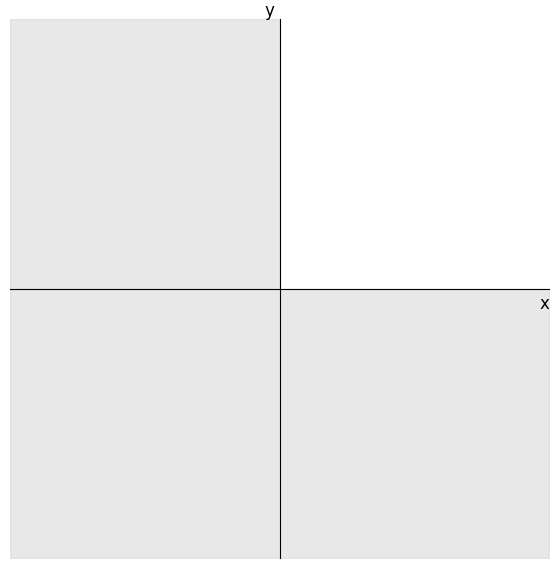

In [32]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# 1. FigureとAxesの準備
fig, ax = plt.subplots(figsize=(7, 7)) # 図のサイズを適宜調整

# 2. 描画範囲の設定
x_min, x_max = -1000, 1000
y_min, y_max = -1000, 1000
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 3. アスペクト比を1:1に設定
ax.set_aspect('equal', adjustable='box')

# 4. 軸を原点で交差させる
ax.spines['left'].set_position('zero')   # y軸をx=0の位置に移動
ax.spines['bottom'].set_position('zero') # x軸をy=0の位置に移動
ax.spines['right'].set_color('none')     # 右側の枠線を非表示
ax.spines['top'].set_color('none')       # 上側の枠線を非表示

# 5. 軸ラベルの設定 (x, y ラベルは残します。不要であればこの部分を削除またはコメントアウトしてください)
ax.set_xlabel('x', loc='right', fontsize=12)
ax.set_ylabel('y', loc='top', rotation=0, fontsize=12)

# 6. 塗りつぶしの設定
fill_color = 'lightgray'  # 塗りつぶしの色
alpha = 0.5               # 透明度
zorder_fill = 0           # 塗りつぶしレイヤーの深さ

#   - x軸より下側全体 (第3象限と第4象限) を塗りつぶす
x_coords_for_neg_y_fill = np.array([x_min, x_max])
ax.fill_between(x_coords_for_neg_y_fill, y_min, 0,
                color=fill_color, alpha=alpha, zorder=zorder_fill)

#   - y軸より左側で、かつx軸より上側 (第2象限) を塗りつぶす
y_coords_for_q2_fill = np.array([0, y_max])
ax.fill_betweenx(y_coords_for_q2_fill, x_min, 0,
                 color=fill_color, alpha=alpha, zorder=zorder_fill)

# 7. グリッド線を非表示にする (★変更点★)
ax.grid(False)

# 8. タイトルはなし

# 9. 目盛りと目盛り数値を非表示にする (★変更点★)
ax.set_xticks([]) # x軸の目盛りと数値を非表示
ax.set_yticks([]) # y軸の目盛りと数値を非表示

# 10. プロットの表示
plt.show()

## if then   ==>

以下の例では、 何れかが正であることを、もし $x$ が正なら $y$ は $0$ 以下であることを `==>` を用いて定義している。

 `solexpand` で内部表現をみると、`!(x > 0) || y <= 0` であることが分かる。

In [ ]:
%%ampl_eval
reset;
var x >= -1000, <= 1000;
var y >= -1000, <= 1000;
maximize total: 5 * x + 2 * y;
s.t. only_one_positive: x > 0 ==> y <= 0;

option solver highs;
solve;
display x,y;

solexpand only_one_positive;

HiGHS 1.10.0: HiGHS 1.10.0: optimal solution; objective 5000
0 simplex iterations
0 branching nodes
x = 1000
y = 0

subject to only_one_positive:
	!(x > 0) || y <= 0;



## if and only if  <==>

以下の例では、 $x$ と $y$ のうちの「ちょうど」1つが正であることを、$x>0$ の必要十分条件が $y \leq 0$ であると表現し、`<==>` を用いて記述している。

In [24]:
%%ampl_eval
reset;
var x >= -1000, <= 1000;
var y >= -1000, <= 1000;
minimize total: 5 * x + 2 * y;
s.t. exactly_one_positive: x > 0 <==> y <= 0;

option solver highs;
solve;
display x,y;

solexpand exactly_one_positive;

HiGHS 1.10.0: optimal solution; objective -4999.9998
0 simplex iterations
0 branching nodes
x = -1000
y = 0.0001

subject to exactly_one_positive:
	x > 0 <==> y <= 0;



制約`exactly_one_positive`を図示すると以下のようになる。

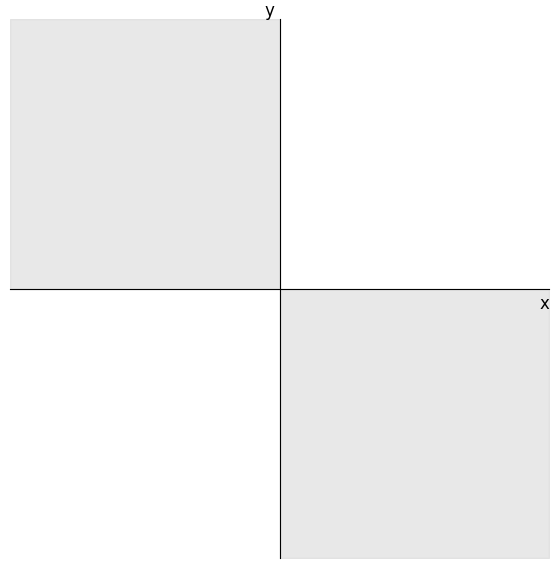

In [13]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# 1. FigureとAxesの準備
fig, ax = plt.subplots(figsize=(7, 7)) # 図のサイズを適宜調整

# 2. 描画範囲の設定
x_min, x_max = -1000, 1000
y_min, y_max = -1000, 1000
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 3. アスペクト比を1:1に設定
ax.set_aspect('equal', adjustable='box')

# 4. 軸を原点で交差させる
ax.spines['left'].set_position('zero')   # y軸をx=0の位置に移動
ax.spines['bottom'].set_position('zero') # x軸をy=0の位置に移動
ax.spines['right'].set_color('none')     # 右側の枠線を非表示
ax.spines['top'].set_color('none')       # 上側の枠線を非表示

# 5. 軸ラベルの設定 (x, y ラベルは残します)
ax.set_xlabel('x', loc='right', fontsize=12)
ax.set_ylabel('y', loc='top', rotation=0, fontsize=12)

# 6. 塗りつぶしの設定
fill_color = 'lightgray'  # 塗りつぶしの色
alpha = 0.5               # 透明度
zorder_fill = 0           # 塗りつぶしレイヤーの深さ

# --- 塗りつぶしロジックの変更 ---
# 6.1. 第2象限 (x < 0, y > 0) を塗りつぶす
#      y座標の範囲 (0からy_maxまで)
y_coords_for_q2_fill = np.array([0, y_max])
#      上記y座標の範囲で、x_minから0までの領域を塗りつぶす
ax.fill_betweenx(y_coords_for_q2_fill, x_min, 0,
                 color=fill_color, alpha=alpha, zorder=zorder_fill)

# 6.2. 第4象限 (x > 0, y < 0) を塗りつぶす
#      x座標の範囲 (0からx_maxまで)
x_coords_for_q4_fill = np.array([0, x_max])
#      上記x座標の範囲で、y_minから0までの領域を塗りつぶす
ax.fill_between(x_coords_for_q4_fill, y_min, 0,
                color=fill_color, alpha=alpha, zorder=zorder_fill)
# --- ここまで ---

# 7. グリッド線を非表示にする
ax.grid(False)

# 8. タイトルはなし

# 9. 目盛りと目盛り数値を非表示にする
ax.set_xticks([]) # x軸の目盛りと数値を非表示
ax.set_yticks([]) # y軸の目盛りと数値を非表示

# 10. プロットの表示
plt.show()

## 選言標準形 

選言標準形 (disjunctive normal form) は、論理式を特定の形式で表現する方法の1つで、
簡単に言うと、「いくつかの（`and`で結ばれたグループ）が、`or`で結ばれた形」 である。

以下の例では、$x$ か $y$ のいずれかが正で、正の場合には$3$以上であることを選言標準形を用いて表現している。

In [11]:
%%ampl_eval
reset;

var x >= -10, <= 10;
var y >= -10, <= 10;
minimize total: 5 * x + 2 * y;
s.t. exactly_one_positive_with_gap:
    (x <= 0 and y >= 3) or (x >= 3 and y <= 0);

option solver highs;
solve;
display x,y;

solexpand exactly_one_positive_with_gap;

HiGHS 1.10.0: optimal solution; objective -44
0 simplex iterations
0 branching nodes
x = -10
y = 3

subject to exactly_one_positive_with_gap:
	x <= 0 && y >= 3 || x >= 3 && y <= 0;



この制約を図示すると以下のようになる。

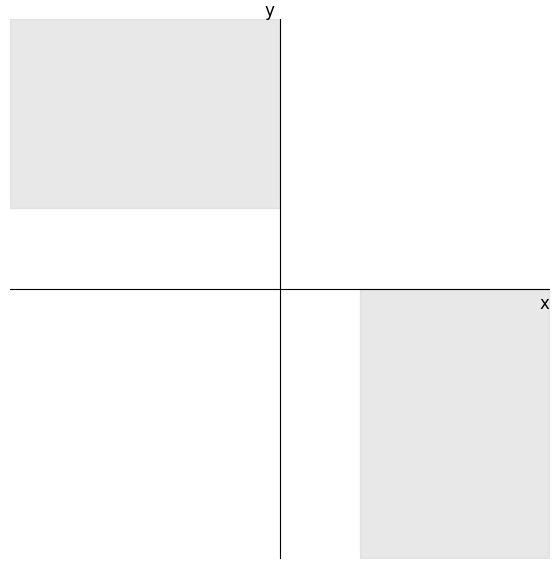

In [16]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# 1. FigureとAxesの準備
fig, ax = plt.subplots(figsize=(7, 7)) # 図のサイズを適宜調整

# 2. 描画範囲の設定
x_min, x_max = -10, 10
y_min, y_max = -10, 10
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 3. アスペクト比を1:1に設定
ax.set_aspect('equal', adjustable='box')

# 4. 軸を原点で交差させる
ax.spines['left'].set_position('zero')   # y軸をx=0の位置に移動
ax.spines['bottom'].set_position('zero') # x軸をy=0の位置に移動
ax.spines['right'].set_color('none')     # 右側の枠線を非表示
ax.spines['top'].set_color('none')       # 上側の枠線を非表示

# 5. 軸ラベルの設定 (x, y ラベルは残します)
ax.set_xlabel('x', loc='right', fontsize=12)
ax.set_ylabel('y', loc='top', rotation=0, fontsize=12)

# 6. 塗りつぶしの設定
fill_color = 'lightgray'  # 塗りつぶしの色
alpha = 0.5               # 透明度
zorder_fill = 0           # 塗りつぶしレイヤーの深さ

# --- 塗りつぶしロジック ---
# 6.1. 領域A (x <= 0 かつ y >= 3) を塗りつぶす
#      y座標の範囲 ([3, y_max])
#      このyの範囲で、xの範囲 ([x_min, 0]) を塗りつぶす
#      y=3 が y_min より大きく、y_max より小さいことを確認 (この場合は明らか)
y_region_A = np.array([3, y_max]) # yは3からy_maxまで
ax.fill_betweenx(y_region_A, x_min, 0, # xはx_minから0まで
                 where=(y_region_A >= 3), # y>=3の条件はy_region_Aの定義でカバーされるが明示
                 color=fill_color, alpha=alpha, zorder=zorder_fill,
                 interpolate=True) # interpolate=Trueで境界を滑らかに（特にwhereを使う場合）

# 6.2. 領域B (x >= 3 かつ y <= 0) を塗りつぶす
#      x座標の範囲 ([3, x_max])
#      このxの範囲で、yの範囲 ([y_min, 0]) を塗りつぶす
#      x=3 が x_min より大きく、x_max より小さいことを確認 (この場合は明らか)
x_region_B = np.array([3, x_max]) # xは3からx_maxまで
ax.fill_between(x_region_B, y_min, 0, # yはy_minから0まで
                where=(x_region_B >= 3), # x>=3の条件はx_region_Bの定義でカバーされるが明示
                color=fill_color, alpha=alpha, zorder=zorder_fill,
                interpolate=True)
# --- ここまで ---

# 7. グリッド線を非表示にする
ax.grid(False)

# 8. タイトルはなし

# 9. 目盛りと目盛り数値を非表示にする
ax.set_xticks([]) # x軸の目盛りと数値を非表示
ax.set_yticks([]) # y軸の目盛りと数値を非表示

# 10. プロットの表示
plt.show()

## 全相異制約  alldiff

8-クイーン問題を例として全相異制約 `alldiff`を説明する。
`alldiff` は引数で与えられる変数がすべて異なる値をとることを表す。

8-クイーン問題では、チェス盤にクイーンの駒（縦横斜めに動ける；将棋の飛車と角の動き）を互いに取り合わないように配置する。

各列に置くクイーンの行番号を表す変数 `Row` が、全て異なり (`row_attacks`)、`Row[j]+j`が全て異なり(`diag_attacks`)、
`Row[j]-j`が全て異なる(`rdiag_attacks`)ことで、クイーンが互いに取り合わないことを規定できる。


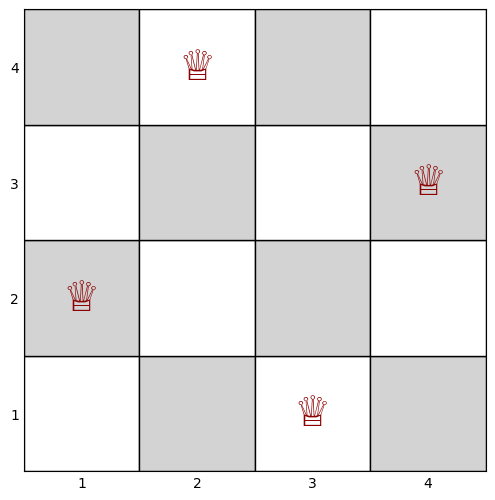

In [24]:
#|echo: false
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# N-Queens problem for N=4
N = 4

# N=4 のクイーン問題の解の一つ (タプルは (列インデックス, 行インデックス)、0-indexed)
# 例: (2,0) は c列 (インデックス2)、1行 (インデックス0) を意味します。
# この解は queen_positions = [(c1), (a2), (d3), (b4)] に対応します。
queen_positions = [(2, 0), (0, 1), (3, 2), (1, 3)]
# 別の有効な解の例: [(1, 0), (3, 1), (0, 2), (2, 3)] # b1, d2, a3, c4

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.set_aspect('equal') # 正方形のマスを正しく表示

# 1. チェス盤のマスを描画
color_light_square = 'white'
color_dark_square = 'lightgray'
# よりチェス盤らしい色の例:
# color_light_square = '#F0D9B5' # 明るいマス
# color_dark_square = '#B58863'  # 暗いマス

for r_idx in range(N):  # 行インデックス (0 から N-1)
    for c_idx in range(N):  # 列インデックス (0 から N-1)
        # マスの色を決定
        if (r_idx + c_idx) % 2 == 0:
            color = color_light_square
        else:
            color = color_dark_square
        
        # 正方形のパッチを作成
        # patches.Rectangle((左下のx座標, 左下のy座標), 幅, 高さ, ...)
        rect = patches.Rectangle(
            (c_idx, r_idx),  # マスの左下の角の座標
            1, 1,            # マスの幅と高さ
            linewidth=1,
            edgecolor='black', # マスの枠線の色
            facecolor=color    # マスの塗りつぶし色
        )
        ax.add_patch(rect)

# 2. クイーンを配置
queen_symbol = "♕"  # U+2655 白いクイーンのシンボル (Unicode)
# queen_symbol = "♛"  # U+265B 黒いクイーンのシンボル (Unicode)
queen_fontsize = 30 # クイーンのシンボルのフォントサイズ (適宜調整)
queen_color = 'darkred'    # クイーンの色 (白黒両方のマスで見やすい色)

# クイーンのシンボル表示に使用するフォントの候補
# 環境にインストールされているフォントを指定してください。
# 一般的なフォント: 'DejaVu Sans', 'Arial Unicode MS', 'Segoe UI Symbol', 'Apple Symbols'
# 指定しない場合、matplotlibのデフォルトフォントが使用されます。
font_for_symbol = 'DejaVu Sans' 

for c_idx, r_idx in queen_positions:
    # マスの中心座標 (x, y)
    x_center = c_idx + 0.5
    y_center = r_idx + 0.5
    
    # クイーンのシンボルをテキストとして描画
    # 注意: ご使用の環境やフォントによっては、クイーンのシンボル(♕)が正しく表示されない場合があります。
    # その場合は、fontname引数で使用可能なフォントを指定するか、
    # ax.scatter() を使ってマーカー（例: 'o'）でクイーンを表すことを検討してください。
    ax.text(x_center, y_center, queen_symbol,
            fontsize=queen_fontsize,
            ha='center',  # 水平方向中央揃え
            va='center',  # 垂直方向中央揃え
            color=queen_color,
            fontname=font_for_symbol) # 指定フォントを使用 (なければmatplotlibがフォールバック試行)

# 3. プロットの範囲とラベルを設定
ax.set_xlim(0, N)
ax.set_ylim(0, N)

# 目盛りを各マスの中央に設定
ax.set_xticks(np.arange(0.5, N, 1))
ax.set_yticks(np.arange(0.5, N, 1))

ax.set_xticklabels([str(i + 1) for i in range(N)])
ax.set_yticklabels([str(i + 1) for i in range(N)]) # 行番号は下から1, 2, ...

# 目盛り線自体は非表示にする (ラベルは残る)
ax.tick_params(axis='both', which='both', length=0)

#plt.title(f"{N}x{N} Queens Problem Solution")
plt.show()

In [29]:
%%ampl_eval
reset;
param n integer > 0;             
var Row {1..n} integer, >= 1, <= n;
s.t. row_attacks: alldiff ({j in 1..n} Row[j]);
s.t. diag_attacks: alldiff ({j in 1..n} Row[j]+j);
s.t. rdiag_attacks: alldiff ({j in 1..n} Row[j]-j);

let n := 8;
option solver gurobi;
solve;
display Row;

solexpand row_attacks;

Gurobi 12.0.1: optimal solution
282 simplex iterations
1 branching node
Objective = find a feasible point.
Row [*] :=
1  7
2  3
3  8
4  2
5  5
6  1
7  6
8  4
;

subject to row_attacks:
	alldiff(Row[1], Row[2], Row[3], Row[4], Row[5], Row[6], Row[7], Row[8]);



## if .. then ..  

以下の例では、ランダムにデータを発生させた施設配置問題において、施設から出る量の合計が正なら、施設の固定費用が必要なことを `if .. then ..`を
用いて記述している。混合整数最適化問題として記述する場合には、施設を開設するとき $1$、それ以外のとき $0$ になる変数が必要であるが、
`if .. then ..`を用いても、自動的に $0$-$1$ 変数を追加して求解してくれる。

In [33]:
%%ampl_eval
reset;
# Set up the sets
set I := 1..5;  # potential facility locations
set J := 1..10;  # customers

# Set up the parameters
param f {i in I} = Normal(60, 20);  # fixed costs for each facility
param c {i in I, j in J} = Uniform(10, 30);  # transportation costs from each facility to each customer
param d {j in J} = Uniform(5, 10);  # demand for each customer

# Set up the decision variables
var x {i in I, j in J} >= 0, <= d[j];  # amount of demand for customer j satisfied by facility i

# Set up the objective function
minimize total_cost:
    sum {i in I, j in J} c[i,j]*x[i,j] +
        sum {i in I} if sum {j in J} x[i,j] > 0 then f[i];

# Set up the constraints
subject to demand_constraint {j in J}:
    sum {i in I} x[i,j] = d[j];

option solver highs;
solve;
display x;

HiGHS 1.10.0: optimal solution; objective 1216.446474
7 simplex iterations
1 branching nodes
x [*,*] (tr)
:       1         2      3      4         5       :=
1    0         0         0   0         7.00354
2    0         7.6232    0   0         0
3    9.89917   0         0   0         0
4    0         0         0   0         9.71021
5    0         0         0   6.95342   0
6    0         5.3371    0   0         0
7    0         0         0   0         5.71001
8    0         0         0   8.05193   0
9    9.23089   0         0   0         0
10   0         9.11613   0   0         0
;



## 不連続な変数の領域

栄養問題を例として、購入量を表す変数 `Buy`が不連続な領域である場合を考える。

最初の例では、区間`[2,5]`か区間`[7,10]`の何れかであることを`union`演算子を用いて表現している。

2番目の例では、$0$ もしくは$10$以上$50$以下であることを表している。

3番目の例では、$0$から$4$も整数、もしくは $9$から$13$の整数、もしくは $17$から$20$の整数であることを表している。

In [38]:
%%ampl_eval
reset;
model;
set NUTR;
set FOOD;
param cost {FOOD} > 0;
param f_min {FOOD} >= 0;
param f_max {j in FOOD} >= f_min[j];
param n_min {NUTR} >= 0;
param n_max {i in NUTR} >= n_min[i];
param amt {NUTR,FOOD} >= 0;

#union of two intervals
var Buy {FOOD} in interval[2, 5] union interval[7,10]; #最初の例
#var Buy {FOOD} in {0} union interval [10, 50];   　　　　　　　　　#2番目の例
#var Buy {FOOD} in 0..4 union 9..13 union 17..20; 　　　　　　　　#3番目の例

minimize Total_Cost: sum {j in FOOD} cost[j] * Buy[j];
subject to Diet {i in NUTR}:
n_min[i] <= sum {j in FOOD} amt[i,j] * Buy[j] <= n_max[i];

data;
set NUTR := A B1 B2 C ;
set FOOD := BEEF CHK FISH HAM MCH MTL SPG TUR ;
param:   cost  f_min  f_max :=
BEEF   3.19    0     100
CHK    2.59    0     100
FISH   2.29    0     100
HAM    2.89    0     100
MCH    1.89    0     100
MTL    1.99    0     100
SPG    1.99    0     100
TUR    2.49    0     100 ;
param:   n_min  n_max :=
A      700   10000
C      700   10000
B1     700   10000
B2     700   10000 ;
param amt (tr):
        A    C   B1   B2 :=
BEEF   60   20   10   15
CHK     8    0   20   20
FISH    8   10   15   10
HAM    40   40   35   10
MCH    15   35   15   15
MTL    70   30   15   15
SPG    25   50   25   15
TUR    60   20   15   10 ;

option solver highs;
solve;
display Buy;

HiGHS 1.10.0: optimal solution; objective 101.0133333
7 simplex iterations
1 branching nodes
Buy [*] :=
BEEF   2
 CHK  10
FISH   2
 HAM   2
 MCH  10
 MTL  10
 SPG   7.33333
 TUR   2
;



## 絶対値  abs

絶対値は`abs`関数で記述できる。

In [ ]:
%%ampl_eval
reset;

var x {1..2} >=-30 <=100;
minimize Objective: abs(x[1]) - 2*abs(x[2]);
s.t. Con1: 3*x[1] - 2*x[2] <=  8;
s.t. Con2: x[1] +   x[2] == 14;

option solver highs;
solve;
display x;

#solexpand Objective;

HiGHS 1.10.0: HiGHS 1.10.0: optimal solution; objective -58
1 simplex iterations
1 branching nodes
x [*] :=
1  -30
2   44
;



## 最大・最小 min, max

複数の式の最大・最小は`max`,`min`関数を用いて記述できる。
以下では最大値の最小化を行っているので、線形最適化問題のまま求解している。これを最小値の最小化に変えると $0$-$1$変数が必要になるので、分枝限定法が実行される。
この際、大きな数 (Big M) を用いるので、変数の範囲を明示的に定義しておくことが望ましい（以下の例では$1000$以下に設定している）。

In [18]:
%%ampl_eval
reset;
#最大値の最小化（BigMは使わない）
var x {1..2} >=0;
minimize Objective: max( 3 * x[1] + 4 * x[2], 2 * x[1] + 7 * x[2]);
s.t. Con1: x[1] + 2 * x[2] >= 12;
s.t. Con2: 2 * x[1] + x[2] >= 15;

option solver highs;
solve;
display x;

HiGHS 1.10.0: optimal solution; objective 31.2
4 simplex iterations
0 barrier iterations
x [*] :=
1  7.2
2  2.4
;



In [19]:
%%ampl_eval
reset;
#最小値の最小化
#Big Mを使うので、明示的に境界を設定する； gurobiだと設定なしでも解けるが、highsではエラーする、
var x {1..2} >=0, <=1000; 
minimize Objective: min( 3 * x[1] + 4 * x[2], 2 * x[1] + 7 * x[2]);
s.t. Con1: x[1] + 2 * x[2] >= 12;
s.t. Con2: 2 * x[1] + x[2] >= 15;

option solver highs;
solve;
display x;

HiGHS 1.10.0: optimal solution; objective 24
8 simplex iterations
1 branching nodes
x [*] :=
1  12
2   0
;



## 区分的線形関数

区分的線形関数 (piecewise linear function) は`<<端点のリスト;傾きのリスト >>`で記述する。

非線形関数 $x^3-2x^2+5$ を区分的線形近似したときの端点と傾きのリストを準備しておく。
傾きの方が、1つ多いことに注意されたい。

In [45]:
def f(x):
  return x**3-2*x**2+5

def fprime(x):
  return 3*x**2-4*x

xlist=[0,1,2,3]
ylist=list(map(f,xlist))
slope = [fprime(xlist[0])]
for i,x in enumerate(xlist[:-1]):
  slope.append(f(xlist[i+1])-f(x))
slope.append(fprime(xlist[-1]))
print(slope)

[0, -1, 1, 9, 15]


以下に、$x^3-2x^2+5$ と $0,1,2,3$を端点とした区分的線形近似関数を示す。

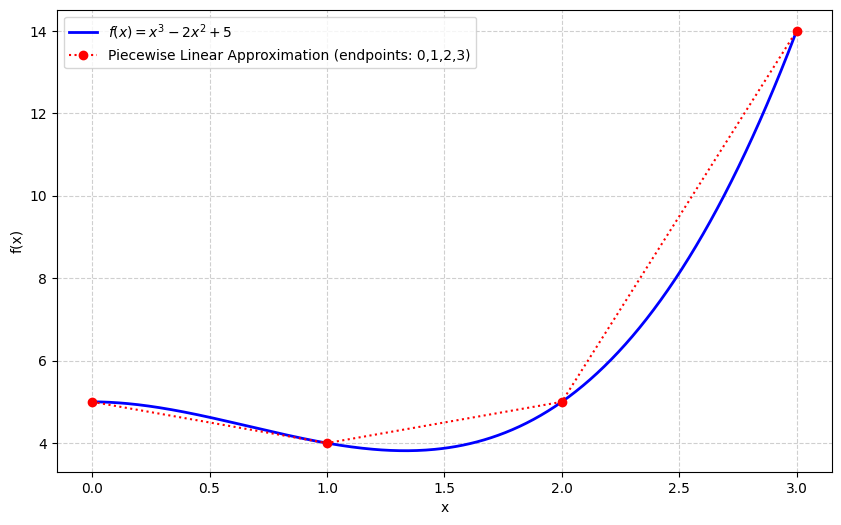

In [31]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# 1. 3次関数の定義
def f(x):
    return x**3 - 2*x**2 + 5

# 2. 3次関数のグラフ用データ生成
# xの範囲 [0, 3] で滑らかな曲線を描くために十分な点を生成
x_smooth = np.linspace(0, 3, 400)
y_smooth = f(x_smooth)

# 3. 区分的線形関数の端点データ生成
# 端点となるxの値
x_linear_points = np.array([0, 1, 2, 3])
# これらのxの値に対応するyの値 (元の3次関数から計算)
y_linear_points = f(x_linear_points)

# 4. グラフの描画
plt.figure(figsize=(10, 6)) # 図のサイズを適宜調整

# 3次関数のプロット (実線)
plt.plot(x_smooth, y_smooth, label=r'$f(x) = x^3 - 2x^2 + 5$', color='blue', linewidth=2)

# 区分的線形関数のプロット (点線、端点にマーカーを表示)
plt.plot(x_linear_points, y_linear_points,
         linestyle=':',  # 点線 (doted line)
         marker='o',       # 端点に丸マーカーを表示
         color='red',
         label='Piecewise Linear Approximation (endpoints: 0,1,2,3)')

# 5. グラフの装飾
#plt.title('Cubic Function and its Piecewise Linear Approximation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, linestyle='--', alpha=0.6) # グリッド線
plt.legend() # 凡例を表示

# 6. プロットの表示
plt.show()

以下のamplのモデルでは、端点のリストはパラメータ`xlist`で、傾きのリストはパラメータ`slope`で表している。
パラメータは展開した形で代入し、`<< >>`の後ろには区分的線形関数を適用する変数`x`を書く。

In [52]:
%%ampl_eval
reset;
var x >=0, <=1000;
param xlist{0..3};
param slope{0..4};
minimize Objective: << {i in 0..3} xlist[i];  {i in 0..4} slope[i] >> x;

In [53]:
ampl.param["xlist"] = xlist
ampl.param["slope"] = slope

In [54]:
%%ampl_eval
option solver highs;
solve;
display x;

HiGHS 1.10.0: optimal solution; objective -1
0 simplex iterations
0 barrier iterations
x = 1



## 数え上げ  count, atleast, atmost

輸送問題を例として `count`, `atleast`, `atmost` を解説する。

`count`は条件を満たす要素の数を**カウント**する演算子である。
以下の例では、$600$以上の輸送量がある経路が少なくとも$7$本あること規定している。

```
subject to Min_Serve:
     count {i in ORIG, j in DEST} (Trans[i,j] >= 600) >= 7;
```

`atmost n`は条件を満たす要素の数が**高々**`n`個であることを規定する。
以下の例では、$1000$以上の輸送量経路が高々$2$本があることを表す。

```
subject to at_most_k:
    atmost 2 {i in ORIG, j in DEST} (Trans[i,j] >= 1000);
```

`atleast n`も同様に、条件を満たす要素の数が**少なくとも**`n`個であることを規定する。

In [ ]:
%%ampl_eval
reset;
model;
set ORIG;   # origins
set DEST;   # destinations

param supply {ORIG} >= 0;   # amounts available at origins
param demand {DEST} >= 0;   # amounts required at destinations

   check: sum {i in ORIG} supply[i] = sum {j in DEST} demand[j];

param cost {ORIG,DEST} >= 0;   # shipment costs per unit
var Trans {ORIG,DEST} >= 0;    # units to be shipped

minimize Total_Cost:
   sum {i in ORIG, j in DEST} cost[i,j] * Trans[i,j];

subject to Supply {i in ORIG}:
   sum {j in DEST} Trans[i,j] = supply[i];

subject to Demand {j in DEST}:
   sum {i in ORIG} Trans[i,j] = demand[j];

#少なくとも7本の経路が600以上の輸送量がある
subject to Min_Serve:
     count {i in ORIG, j in DEST} (Trans[i,j] >= 600) >= 7;

#高々2本の経路が1000以上の輸送量がある（等号のtrickで3本のように見えるが、1000-epsilonと解釈）
#subject to at_most_k:
#    atmost 2 {i in ORIG, j in DEST} (Trans[i,j] >= 1000);

data;
param: ORIG:  supply :=  # defines set "ORIG" and param "supply"
        GARY   1400
        CLEV   2600
        PITT   2900 ;

param: DEST:  demand :=  # defines "DEST" and "demand"
        FRA     900
        DET    1200
        LAN     600
        WIN     400
        STL    1700
        FRE    1100
        LAF    1000 ;

param cost:
         FRA  DET  LAN  WIN  STL  FRE  LAF :=
   GARY   39   14   11   14   16   82    8
   CLEV   27    9   12    9   26   95   17
   PITT   24   14   17   13   28   99   20 ;

option solver gurobi; #highsだと解けない
solve;
display Trans;

Gurobi 12.0.1:   tech:writegraph = model.jsonl
Gurobi 12.0.1: optimal solution; objective 197000
26 simplex iterations
1 branching node
Trans [*,*] (tr)
:     CLEV   GARY   PITT    :=
DET   1200      0      0
FRA      0      0    900
FRE      0   1100      0
LAF      0    300    700
LAN    600      0      0
STL    600      0   1100
WIN    200      0    200
;



## 非線形関数

以下の非線形関数をそのまま記述することができる。

- log (expr), log10 (expr)
- exp (expr)
- sin (expr), cos (expr), tan (expr), asin (expr), acos (expr), atan (expr)
- sinh (expr), cosh (expr), tanh (expr), asinh (expr), acosh (expr), atanh (expr)
- expr1 ^ expr2

ソルバーが対応可能な場合はそのまま、非対応の場合には区分的線形関数に近似する。

例として、3次関数 $x^3-2x^2+5$ の最小化を行う。区分的線形近似のためには、変数 $x$ の範囲を明示的に定義しておく必要がある。

自動的に区分的線形近似が行われ、最適解$4/3=1.33\cdots$に近い解が得られることが確認できる。

In [38]:
%%ampl_eval
reset;
model;
var x >=0, <=3;
minimize Objective: x^3-2*x^2+5;
option solver gorobi; #highsだと間違える；gurobiかscipもしくは非線形最適化ソルバー(knitro, ipopt)を用いる
solve;
display x;

Cannot find "gorobi"
x = 0

